In [1]:
import cv2 as cv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
#matplotlib inline
matplotlib.rcParams['figure.figsize'] = [10, 8]

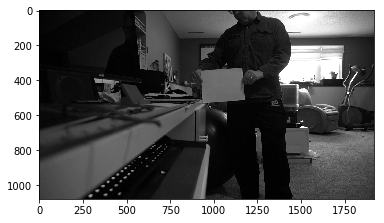

In [2]:
start_sec = 15
frames = start_sec * 30
cap = cv.VideoCapture("videos/C0065.MP4")
while cap.isOpened() & (frames > 0):
    ret, img = cap.read()
    frames -= 1
    
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.imshow(gray, cmap='gray')

In [17]:
def draw_paper(img, cnts, idx = 0):
    draw = cv.drawContours(img.copy(), cnts, idx, (0, 0, 255), thickness=3)
    plt.imshow(cv.cvtColor(draw, cv.COLOR_BGR2RGB))

In [67]:
def find_paper(img, 
               ct1 = 35, 
               ct2 = 125, 
               ca = 5, 
               morph_size = 5, 
               min_area_per = 0.01,
               min_ratio = 0.7, 
               max_arc_per = 1.5,
               debug = 0):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    canny = cv.Canny(gray, ct1, ct2, ca)
    cv.imwrite("canny.bmp", canny)
    se = cv.getStructuringElement(cv.MORPH_CROSS, (morph_size, morph_size))
    morph = cv.morphologyEx(canny, cv.MORPH_CLOSE, se, iterations=1)
    cv.imwrite("morph.bmp", morph)
    
    (H, W) = gray.shape
    min_area = (H*W) * min_area_per
    max_ratio = 1/min_ratio
    max_arc = (H*W) * max_arc_per
    min_arc = (H*W) * max_arc_per
    cnts, heir = cv.findContours(morph, cv.RETR_LIST , cv.CHAIN_APPROX_SIMPLE)
    print("Found {} contours".format(len(cnts)))
    #Find a contour that is roughly square
    print("Looking for contours with min area {}".format(min_area))
    print("Looking for contours with ratio {}-{}".format(min_ratio, max_ratio))
    print("Looking for contours with max arc {}".format(max_arc))
    filters = []
    for c in cnts:
        approx = cv.approxPolyDP(c, 10, True)
        area = cv.contourArea(approx)
        if area > min_area:
            rect = cv.minAreaRect(approx)
            ratio = rect[1][0] / rect[1][1]
            arc = cv.arcLength(approx, True)
            star = ''
            max_arc = math.sqrt(area) * 4 * max_arc_per
            if (ratio > min_ratio) & (ratio < max_ratio):    
                if arc < max_arc:
                    filters.append(approx)                    
                    star = '*'
            print("{}Area: {} - Ratio: {} - Arc: {}".format(star, area, ratio, arc))

    if debug == 1:        
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    elif debug == 2:
        plt.imshow(canny, cmap='gray')
    elif debug == 3:
        plt.imshow(morph, cmap='gray')
                    
    return filters


Found 1114 contours
Looking for contours with min area 2073.6
Looking for contours with ratio 0.7-1.4285714285714286
Looking for contours with max arc 3110400.0
Area: 12215.5 - Ratio: 1.09084564516006 - Arc: 1465.037359237671
Area: 3644.5 - Ratio: 0.18969457113095956 - Arc: 332.12645721435547
Area: 11168.0 - Ratio: 0.07421798313714392 - Arc: 921.6613864898682
Area: 111922.0 - Ratio: 1.1272321428571428 - Arc: 4536.008008956909
Area: 3493.0 - Ratio: 0.3027558089877091 - Arc: 572.138180732727
*Area: 5214.5 - Ratio: 0.7576894643405646 - Arc: 427.2642593383789
Area: 9854.0 - Ratio: 0.6946510536601257 - Arc: 401.9809741973877
Area: 3743.5 - Ratio: 0.3074509715196266 - Arc: 369.95109367370605
Area: 8658.0 - Ratio: 0.7315054691540979 - Arc: 1189.9290742874146
Area: 30128.5 - Ratio: 1.4898240324868848 - Arc: 1171.025598526001
Area: 33066.5 - Ratio: 2.548954819617039 - Arc: 1740.3175201416016
Area: 2204.5 - Ratio: 0.1572140024945169 - Arc: 274.77981185913086
Area: 2413.5 - Ratio: 0.3344920295984

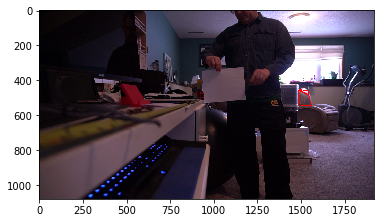

In [69]:
cnts = find_paper(img, debug=3, ct1=35, ct2=100, min_area_per=0.001)
draw_paper(img, cnts, 0)
print(len(cnts))

In [8]:
def distance_to_camera(knownWidth, focalLength, perWidth):
    return (knownWidth * focalLength) / perWidth

def get_per_width(cnt):
    rect = cv.minAreaRect(cnt)
    print(rect)
    pix_width = max(rect[1][0], rect[1][1])
    return pix_width

KNOWN_DISTANCE = 59
KNOWN_WIDTH = 11
pix_width = get_per_width(cnts[0])
focal_length = (pix_width * KNOWN_DISTANCE) / KNOWN_WIDTH
print(focal_length)    

((1648.324951171875, 853.7659301757812), (456.954345703125, 458.6732177734375), -2.4263358116149902)
2460.15634987571


Found 738 contours
Looking for contours with min area 20736.0
Looking for contours with ratio 0.7-1.4285714285714286
Looking for contours with max arc 20736.0
Area: 84740.0 - Ratio: 0.9617589307961908 - Arc: 4380.679718017578
Area: 33547.5 - Ratio: 2.4743342902282586 - Arc: 1547.7723407745361
Area: 105969.5 - Ratio: 0.5664132091952588 - Arc: 6923.2052001953125
Area: 54717.5 - Ratio: 0.7760441625199724 - Arc: 10785.400556564331


IndexError: list index out of range

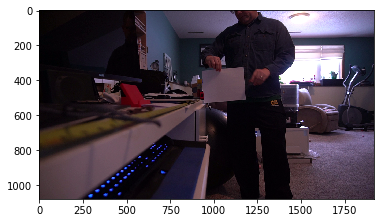

In [33]:
skip = 5
while skip > 0:
    ret, img = cap.read()
    skip -= 1
cnts = find_paper(img)
per_width = get_per_width(cnts[0])
distance = distance_to_camera(KNOWN_WIDTH, focal_length, per_width)
print("per_width: {} distance: {}".format(per_width, distance))
draw_paper(img, cnts)